In [24]:
import os
import argparse
from solver import Solver
from data_loader import get_loader
from torch.backends import cudnn

import numpy as np
import os
import time
import datetime

import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image

from utils import *
from models import Generator, Discriminator
from data.sparse_molecular_dataset import SparseMolecularDataset
from rdkit import Chem
import matplotlib

def str2bool(v):
    return v.lower() in ('true')

In [25]:
parser = argparse.ArgumentParser()

# Model configuration.
parser.add_argument('--z_dim', type=int, default=8, help='dimension of domain labels')
parser.add_argument('--g_conv_dim', default=[128,256,512], help='number of conv filters in the first layer of G')
parser.add_argument('--d_conv_dim', type=int, default=[[128, 64], 128, [128, 64]], help='number of conv filters in the first layer of D')
parser.add_argument('--g_repeat_num', type=int, default=6, help='number of residual blocks in G')
parser.add_argument('--d_repeat_num', type=int, default=6, help='number of strided conv layers in D')
parser.add_argument('--lambda_cls', type=float, default=1, help='weight for domain classification loss')
parser.add_argument('--lambda_rec', type=float, default=10, help='weight for reconstruction loss')
parser.add_argument('--lambda_gp', type=float, default=10, help='weight for gradient penalty')
parser.add_argument('--post_method', type=str, default='softmax', choices=['softmax', 'soft_gumbel', 'hard_gumbel'])

# Training configuration.
parser.add_argument('--batch_size', type=int, default=128, help='mini-batch size')
parser.add_argument('--num_iters', type=int, default=10000, help='number of total iterations for training D')
parser.add_argument('--num_iters_decay', type=int, default=5000, help='number of iterations for decaying lr')
parser.add_argument('--g_lr', type=float, default=0.0001, help='learning rate for G')
parser.add_argument('--d_lr', type=float, default=0.0001, help='learning rate for D')
parser.add_argument('--dropout', type=float, default=0., help='dropout rate')
parser.add_argument('--n_critic', type=int, default=5, help='number of D updates per each G update')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for Adam optimizer')
parser.add_argument('--beta2', type=float, default=0.999, help='beta2 for Adam optimizer')
parser.add_argument('--resume_iters', type=int, default=None, help='resume training from this step')

# Test configuration.
parser.add_argument('--test_iters', type=int, default=10000, help='test model from this step')

# Miscellaneous.
parser.add_argument('--num_workers', type=int, default=1)
parser.add_argument('--mode', type=str, default='test', choices=['train', 'test'])
parser.add_argument('--use_tensorboard', type=str2bool, default=False)

# Directories.
parser.add_argument('--mol_data_dir', type=str, default='data/gdb9_9nodes.sparsedataset')
parser.add_argument('--log_dir', type=str, default='molgan/logs')
parser.add_argument('--model_save_dir', type=str, default='molgan/models')
parser.add_argument('--sample_dir', type=str, default='molgan/samples')
parser.add_argument('--result_dir', type=str, default='molgan/results')

# Step size.
parser.add_argument('--log_step', type=int, default=10)
parser.add_argument('--sample_step', type=int, default=1000)
parser.add_argument('--model_save_step', type=int, default=10000)
parser.add_argument('--lr_update_step', type=int, default=1000)

config = parser.parse_known_args()[0]
print(config)

# For fast training.
cudnn.benchmark = True

Namespace(batch_size=128, beta1=0.5, beta2=0.999, d_conv_dim=[[128, 64], 128, [128, 64]], d_lr=0.0001, d_repeat_num=6, dropout=0.0, g_conv_dim=[128, 256, 512], g_lr=0.0001, g_repeat_num=6, lambda_cls=1, lambda_gp=10, lambda_rec=10, log_dir='molgan/logs', log_step=10, lr_update_step=1000, mode='test', model_save_dir='molgan/models', model_save_step=10000, mol_data_dir='data/gdb9_9nodes.sparsedataset', n_critic=5, num_iters=10000, num_iters_decay=5000, num_workers=1, post_method='softmax', result_dir='molgan/results', resume_iters=None, sample_dir='molgan/samples', sample_step=1000, test_iters=10000, use_tensorboard=False, z_dim=8)


In [26]:
self = Solver(config)

Generator(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0, inplace=True)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.0, inplace=True)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.0, inplace=True)
  )
  (edges_layer): Linear(in_features=512, out_features=405, bias=True)
  (nodes_layer): Linear(in_features=512, out_features=45, bias=True)
  (dropoout): Dropout(p=0.0, inplace=False)
)
G
The number of parameters: 396610
Discriminator(
  (gcn_layer): GraphConvolution(
    (linear1): Linear(in_features=5, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (agg_layer): GraphAggregation(
    (sigmoid_linear): Sequential(
      (0): Linear(in_features=69, out_features=128, bias=True)
      (1): Sigmoid()
    )
    (tan

In [27]:
self.D

Discriminator(
  (gcn_layer): GraphConvolution(
    (linear1): Linear(in_features=5, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (agg_layer): GraphAggregation(
    (sigmoid_linear): Sequential(
      (0): Linear(in_features=69, out_features=128, bias=True)
      (1): Sigmoid()
    )
    (tanh_linear): Sequential(
      (0): Linear(in_features=69, out_features=128, bias=True)
      (1): Tanh()
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Dropout(p=0.0, inplace=False)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Dropout(p=0.0, inplace=False)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [28]:
def restore_model(self, resume_iters):
    """Restore the trained generator and discriminator."""
    print('Loading the trained models from step {}...'.format(resume_iters))
    G_path = os.path.join(self.model_save_dir, '{}-G.ckpt'.format(resume_iters))
    D_path = os.path.join(self.model_save_dir, '{}-D.ckpt'.format(resume_iters))
    V_path = os.path.join(self.model_save_dir, '{}-V.ckpt'.format(resume_iters))
    self.G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))
    self.D.load_state_dict(torch.load(D_path, map_location=lambda storage, loc: storage))
    self.V.load_state_dict(torch.load(V_path, map_location=lambda storage, loc: storage))

In [29]:
self.restore_model(50000)

Loading the trained models from step 50000...


In [84]:
# Learning rate cache for decaying.
g_lr = self.g_lr
d_lr = self.d_lr

# Start training from scratch or resume training.
start_iters = 0
self.resume_iters = 50000
if self.resume_iters:
    start_iters = self.resume_iters
    self.restore_model(self.resume_iters)
    
# Start training.
print('Start training...')
start_time = time.time()
cnt = 0
for i in range(50000, 100000): #self.num_iters
    cnt += 1
    if (i+1) % self.log_step == 0:
        mols, _, _, a, x, _, _, _, _ = self.data.next_validation_batch()
        z = self.sample_z(a.shape[0])
        print('[Valid]', '')
    else:
        mols, _, _, a, x, _, _, _, _ = self.data.next_train_batch(self.batch_size)
        z = self.sample_z(self.batch_size)
        

        # =================================================================================== #
        #                             1. Preprocess input data                                #
        # =================================================================================== #

        a = torch.from_numpy(a).to(self.device).long()            # Adjacency.
        x = torch.from_numpy(x).to(self.device).long()            # Nodes.
        a_tensor = self.label2onehot(a, self.b_dim)
        x_tensor = self.label2onehot(x, self.m_dim)
        z = torch.from_numpy(z).to(self.device).float()

        # =================================================================================== #
        #                             2. Train the discriminator                              #
        # =================================================================================== #

        # Compute loss with real images.
        logits_real, features_real = self.D(a_tensor, None, x_tensor)
        d_loss_real = - torch.mean(logits_real)

        # Compute loss with fake images.
        edges_logits, nodes_logits = self.G(z)
        # Postprocess with Gumbel softmax
        (edges_hat, nodes_hat) = self.postprocess((edges_logits, nodes_logits), self.post_method)
        logits_fake, features_fake = self.D(edges_hat, None, nodes_hat)
        d_loss_fake = torch.mean(logits_fake)

        # Compute loss for gradient penalty.
        eps = torch.rand(logits_real.size(0),1,1,1).to(self.device)
        x_int0 = (eps * a_tensor + (1. - eps) * edges_hat).requires_grad_(True)
        x_int1 = (eps.squeeze(-1) * x_tensor + (1. - eps.squeeze(-1)) * nodes_hat).requires_grad_(True)
        grad0, grad1 = self.D(x_int0, None, x_int1)
        d_loss_gp = self.gradient_penalty(grad0, x_int0) + self.gradient_penalty(grad1, x_int1)


        # Backward and optimize.
        d_loss = d_loss_fake + d_loss_real + self.lambda_gp * d_loss_gp
        self.reset_grad()
        d_loss.backward()
        self.d_optimizer.step()

        # Logging.
        loss = {}
        loss['D/loss_real'] = d_loss_real.item()
        loss['D/loss_fake'] = d_loss_fake.item()
        loss['D/loss_gp'] = d_loss_gp.item()

        # =================================================================================== #
        #                               3. Train the generator                                #
        # =================================================================================== #

        if (i+1) % self.n_critic == 0 or True:
            # Z-to-target
            edges_logits, nodes_logits = self.G(z)
            # Postprocess with Gumbel softmax
            (edges_hat, nodes_hat) = self.postprocess((edges_logits, nodes_logits), self.post_method)
            logits_fake, features_fake = self.D(edges_hat, None, nodes_hat)
            g_loss_fake = - torch.mean(logits_fake)

            # Real Reward
            rewardR = torch.from_numpy(self.reward(mols)).to(self.device)
            # Fake Reward
            (edges_hard, nodes_hard) = self.postprocess((edges_logits, nodes_logits), 'hard_gumbel')
            edges_hard, nodes_hard = torch.max(edges_hard, -1)[1], torch.max(nodes_hard, -1)[1]
            mols = [self.data.matrices2mol(n_.data.cpu().numpy(), e_.data.cpu().numpy(), strict=True)
                    for e_, n_ in zip(edges_hard, nodes_hard)]
            rewardF = torch.from_numpy(self.reward(mols)).to(self.device)

            # Value loss
            value_logit_real,_ = self.V(a_tensor, None, x_tensor, torch.sigmoid)
            value_logit_fake,_ = self.V(edges_hat, None, nodes_hat, torch.sigmoid)
            g_loss_value = torch.mean((value_logit_real - rewardR) ** 2 + (
                                       value_logit_fake - rewardF) ** 2)
            #rl_loss= -value_logit_fake
            #f_loss = (torch.mean(features_real, 0) - torch.mean(features_fake, 0)) ** 2

            # Backward and optimize.
            g_loss = g_loss_fake + g_loss_value
            self.reset_grad()
            g_loss.backward()
            self.g_optimizer.step()

            # Logging.
            loss['G/loss_fake'] = g_loss_fake.item()
            loss['G/loss_value'] = g_loss_value.item() 
        if cnt == 12:
            break

Loading the trained models from step 50000...
Start training...


RDKit ERROR: [15:53:14] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [15:53:14] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [15:53:14] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [15:53:14] Explicit valence for atom # 1 C, 8, is greater than permitted
RDKit ERROR: [15:53:14] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [15:53:14] non-ring atom 0 marked aromatic
RDKit ERROR: [15:53:14] non-ring atom 0 marked aromatic
RDKit ERROR: [15:53:14] non-ring atom 0 marked aromatic
RDKit ERROR: [15:53:14] Explicit valence for atom # 1 C, 8, is greater than permitted
RDKit ERROR: [15:53:14] non-ring atom 0 marked aromatic
RDKit ERROR: [15:53:14] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [15:53:14] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [15:53:14] Explicit valence for atom # 5 O, 3, is greater than permitted
RD

RDKit ERROR: [15:53:14] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [15:53:14] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [15:53:14] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [15:53:14] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:53:14] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [15:53:14] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [15:53:14] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [15:53:14] non-ring atom 0 marked aromatic
RDKit ERROR: [15:53:14] non-ring atom 0 marked aromatic
RDKit ERROR: [15:53:14] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [15:53:14] non-ring atom 1 marked aromatic
RDKit ERROR: [15:53:14] non-ring atom 0 marked aromatic
RDKit ERROR: [15:53:14] Explicit valence for atom # 3 C, 5, is greater than permitted
RD

RDKit ERROR: [15:53:15] Explicit valence for atom # 3 C, 8, is greater than permitted
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [15:53:15] non-ring atom 1 marked aromatic
RDKit ERROR: [15:53:15] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [15:53:15] non-ring atom 1 marked aromatic
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:53:15] Explicit valence for atom # 2 N, 7, is greater than permitted
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:53:15] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [15:53:15] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [15:53:15] non-ring atom 6 marked aromatic
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 O, 6

RDKit ERROR: [15:53:15] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [15:53:15] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [15:53:15] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 C, 8, is greater than permitted
RDKit ERROR: [15:53:15] Can't kekulize mol.  Unkekulized atoms: 2
RDKit ERROR: 
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:53:15] non-ring atom 0 marked aromatic
RDKit ERROR: [15:53:15] non-ring atom 7 marked aromatic
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [15:53:15] non-ring a

RDKit ERROR: [15:53:15] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [15:53:15] Explicit valence for atom # 3 C, 6, is greater than permitted
RDKit ERROR: [15:53:15] non-ring atom 0 marked aromatic
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [15:53:15] non-ring atom 0 marked aromatic
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [15:53:15] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:53:15] non-ring atom 0 marked aromatic
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 O, 5

RDKit ERROR: [15:53:15] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 O, 6, is greater than permitted
RDKit ERROR: [15:53:15] non-ring atom 0 marked aromatic
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 C, 8, is greater than permitted
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [15:53:15] non-ring atom 1 marked aromatic
RDKit ERROR: [15:53:15] non-ring atom 7 marked aromatic
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [15:53:15] non-ring atom 0 marked aromatic
RDKit ERROR: [15:53:15] Explicit valence for atom # 1 C, 6, is greater than permitted
RD

RDKit ERROR: [15:53:16] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:53:16] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [15:53:16] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [15:53:16] non-ring atom 7 marked aromatic
RDKit ERROR: [15:53:16] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [15:53:16] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [15:53:16] non-ring atom 1 marked aromatic
RDKit ERROR: [15:53:16] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [15:53:16] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [15:53:16] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [15:53:16] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:53:16] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [15:53:16] non-

RDKit ERROR: [15:53:16] non-ring atom 0 marked aromatic
RDKit ERROR: [15:53:16] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [15:53:16] Explicit valence for atom # 2 N, 6, is greater than permitted
RDKit ERROR: [15:53:16] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [15:53:16] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:53:16] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [15:53:16] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:53:16] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [15:53:16] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [15:53:16] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [15:53:16] non-ring atom 1 marked aromatic
RDKit ERROR: [15:53:16] non-ring atom 0 marked aromatic
RDKit ERROR: [15:53:16] Explicit valence for atom # 4 C, 5

RDKit ERROR: [15:53:16] Explicit valence for atom # 1 C, 8, is greater than permitted
RDKit ERROR: [15:53:16] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [15:53:16] non-ring atom 0 marked aromatic
RDKit ERROR: [15:53:16] non-ring atom 0 marked aromatic
RDKit ERROR: [15:53:16] non-ring atom 7 marked aromatic
RDKit ERROR: [15:53:16] non-ring atom 1 marked aromatic
RDKit ERROR: [15:53:16] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [15:53:16] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:53:16] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:53:16] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:53:16] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [15:53:16] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [15:53:16] non-ring atom 0 marked aromatic
RDKit ERROR: [15:53:16] Explicit

[Valid] 


RDKit ERROR: [15:53:17] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:53:17] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:53:17] non-ring atom 7 marked aromatic
RDKit ERROR: [15:53:17] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:53:17] Explicit valence for atom # 1 C, 8, is greater than permitted
RDKit ERROR: [15:53:17] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [15:53:17] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [15:53:17] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [15:53:17] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:53:17] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [15:53:17] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [15:53:17] Explicit valence for atom # 1 O, 3, is greater than permitte

RDKit ERROR: [15:53:17] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [15:53:17] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:53:17] non-ring atom 0 marked aromatic
RDKit ERROR: [15:53:17] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:53:17] non-ring atom 0 marked aromatic
RDKit ERROR: [15:53:17] non-ring atom 0 marked aromatic
RDKit ERROR: [15:53:17] Explicit valence for atom # 3 C, 8, is greater than permitted
RDKit ERROR: [15:53:17] non-ring atom 0 marked aromatic
RDKit ERROR: [15:53:17] Explicit valence for atom # 2 N, 6, is greater than permitted
RDKit ERROR: [15:53:17] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [15:53:17] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [15:53:17] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [15:53:17] Explicit valence for atom # 1 C, 6, is greater than permitted
RD

In [95]:
features_fake[0]

tensor([-0.3577,  0.5198, -0.2200, -0.1941, -0.0588, -0.0324, -0.2188,  0.4369,
        -0.0785, -0.1906,  0.1123, -0.1006, -0.7041, -0.3464, -0.0472, -0.0889,
        -0.0607,  0.1470,  0.2462, -0.0529,  0.1750, -0.5404, -0.0218,  0.1736,
        -0.0696, -0.0652,  0.2261,  0.1499, -0.2163, -0.0508, -0.3157, -0.0305,
         0.3861, -0.3027,  0.1714, -0.3838,  0.2379,  0.3399,  0.0085, -0.1420,
        -0.4310,  0.3126, -0.4774, -0.1028, -0.1677,  0.5550,  0.2454, -0.0035,
         0.3076, -0.1066, -0.0391,  0.3358,  0.0958, -0.0572, -0.0938, -0.2069,
        -0.2597,  0.2203,  0.0761, -0.0869,  0.0744,  0.0239,  0.5163,  0.0115],
       grad_fn=<SelectBackward>)

In [9]:
g_loss

tensor(-0.1428, grad_fn=<AddBackward0>)

In [10]:
d_loss

tensor(0.2197, grad_fn=<AddBackward0>)

In [11]:
mols, _, _, a, x, _, _, _, _ = self.data.next_validation_batch()

In [23]:
[[0, 1, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 2, 0, 0, 0, 0, 0],
       [0, 0, 2, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 1, 0]]

[[0, 1, 0, 0, 0, 0, 0, 0, 1],
 [1, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 2, 0, 0, 0, 0, 0],
 [0, 0, 2, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 2, 0, 0, 0],
 [0, 0, 0, 0, 2, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 1],
 [1, 0, 0, 0, 0, 0, 0, 1, 0]]

In [12]:
a[0]

array([[0, 1, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 2, 0, 0, 0, 0, 0],
       [0, 0, 2, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 1, 0]], dtype=int32)

In [13]:
x[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 3], dtype=int32)

In [14]:
# Load the trained generator.
self.restore_model(50000)

with torch.no_grad():
    mols, _, _, a, x, _, _, _, _ = self.data.next_test_batch()
    z = self.sample_z(a.shape[0])
    z = torch.from_numpy(z).to(self.device).float()
    
    edges_logits, nodes_logits = self.G(z)
    (edges_hat, nodes_hat) = self.postprocess((edges_logits, nodes_logits), self.post_method)
    logits_fake, features_fake = self.D(edges_hat, None, nodes_hat)
    g_loss_fake = - torch.mean(logits_fake)
    
    # Fake Reward
    (edges_hard, nodes_hard) = self.postprocess((edges_logits, nodes_logits), 'hard_gumbel')
    edges_hard, nodes_hard = torch.max(edges_hard, -1)[1], torch.max(nodes_hard, -1)[1]
    mols = [self.data.matrices2mol(n_.data.cpu().numpy(), e_.data.cpu().numpy(), strict=True)
            for e_, n_ in zip(edges_hard, nodes_hard)]

Loading the trained models from step 50000...


RDKit ERROR: [16:26:07] Explicit valence for atom # 2 N, 6, is greater than permitted
RDKit ERROR: [16:26:07] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:07] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [16:26:07] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:26:07] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:26:07] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:07] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:07] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:07] non-ring atom 1 marked aromatic
RDKit ERROR: [16:26:07] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:07] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:07] Explicit valence for atom # 1 C, 8, is greater than permitted
RDKit ERROR: [16:26:07] Explicit valence for atom # 1 C, 6

RDKit ERROR: [16:26:07] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:07] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:07] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:07] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:07] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:07] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:07] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:07] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:07] non-ring atom 1 marked aromatic
RDKit ERROR: [16:26:07] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:26:07] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:07] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:07] Explicit valence for atom # 1 O, 5

RDKit ERROR: [16:26:08] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:08] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:08] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:08] non-ring atom 6 marked aromatic
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 0 C, 6

RDKit ERROR: [16:26:08] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:08] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:08] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:08] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:08] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 C, 8, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 C, 7, is greater than permitted
RD

RDKit ERROR: [16:26:08] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:08] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:08] Explicit valence for atom # 2 N, 6, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 C, 8, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 C, 6, is greater than permitte

RDKit ERROR: [16:26:08] non-ring atom 7 marked aromatic
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 3 C, 8, is greater than permitted
RDKit ERROR: [16:26:08] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:08] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [16:26:08] non-ring atom 1 marked aromatic
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 C, 5, is greater than permitted
RD

RDKit ERROR: [16:26:08] Explicit valence for atom # 1 O, 6, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:08] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:08] Explicit valence for atom # 2 N, 6, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [16:26:08] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 C, 8, is greater than permitted
RDKit ERROR: [16:26:08] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:08] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:08] non-ring atom 0 marked aromatic
RD

RDKit ERROR: [16:26:09] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:09] non-ring atom 3 marked aromatic
RDKit ERROR: [16:26:09] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:09] non-ring atom 1 marked aromatic
RDKit ERROR: [16:26:09] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 3 C, 8, is greater than permitted
RDKit ERROR: [16:26:09] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:26:09] non-ring atom 7 marked aromatic
RDKit ERROR: [16:26:09] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit 

RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [16:26:09] non-ring atom 1 marked aromatic
RDKit ERROR: [16:26:09] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:09] non-ring atom 3 marked aromatic
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 2 N, 8, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 6

RDKit ERROR: [16:26:09] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 N, 6, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:09] non-ring atom 3 marked aromatic
RDKit ERROR: [16:26:09] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 6, is greater than permitte

RDKit ERROR: [16:26:09] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 2 N, 6, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:09] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:09] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:09] Explicit valence for atom # 2 N, 6, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 O, 5

RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:09] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 6 C, 8, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 6 C, 6, is greater than permitted
RDKit ERROR: [16:26:09] Explicit valence for atom # 1 O, 3, is greater than permitte

RDKit ERROR: [16:26:10] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 6 C, 7, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [16:26:10] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 8, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 8, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [16:26:10] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:10] Explicit valence for atom # 3 C, 8, is greater than permitted
RDKit ERROR: [16:26:10] non-

RDKit ERROR: [16:26:10] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 O, 6, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 8, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 5, is greater than permitte

RDKit ERROR: [16:26:10] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:10] non-ring atom 1 marked aromatic
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 2 N, 4, is greater than permitte

RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 8, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 4 N, 6, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:10] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:26:10] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [16:26:10] Expl

RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:10] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 3 C, 8, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 

RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 2 N, 8, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:11] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 5, is greater than permitte

RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:11] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:11] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [16:26:11] non-ring atom 7 marked aromatic
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 6 C, 6, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:11] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 3 C, 8

RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 8, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [16:26:11] non-ring atom 7 marked aromatic
RDKit ERROR: [16:26:11] Can't kekulize mol.  Unkekulized atoms: 8
RDKit ERROR: 
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 8, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKi

RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:11] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:11] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:11] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 8, is greater than permitted
RDKit ERROR: [16:26:11] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:11] Expl

RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:12] non-ring atom 1 marked aromatic
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:12] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [16:26:12] Expl

RDKit ERROR: [16:26:12] non-ring atom 1 marked aromatic
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 2 N, 6, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 O, 6, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 O, 5, is greater than permitte

RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:12] non-ring atom 3 marked aromatic
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [16:26:12] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:12] Expl

RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 9, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [16:26:12] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 8, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 5 O, 3, is greater than permitte

RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 2 N, 7, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:26:12] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 6 C, 6, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:12] Explicit valence for atom # 1 C, 6, is greater than permitte

RDKit ERROR: [16:26:13] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:13] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [16:26:13] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:26:13] Explicit valence for atom # 6 C, 6, is greater than permitted
RDKit ERROR: [16:26:13] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:13] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:13] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:13] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:13] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:13] Explicit valence for atom # 1 C, 8, is greater than permitted
RDKit ERROR: [16:26:13] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [16:26:13] Explicit valence for atom # 1 C, 8, is greater than permitte

RDKit ERROR: [16:26:13] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:13] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:13] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:13] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:13] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:13] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:26:13] Explicit valence for atom # 1 O, 5, is greater than permitted
RDKit ERROR: [16:26:13] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [16:26:13] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:13] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:13] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [16:26:13] Explicit valence for atom # 2 N, 5, is greater than permitted
RDKit ERROR: [16:26:13] non-ring atom 0 marked aromatic
RDKit ERROR: [16:26:13] Explicit

In [15]:
a.shape[0]

13317

In [16]:
edges_hard[12]

tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 2, 3, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 2, 0, 0, 0, 3, 2, 0, 0],
        [0, 3, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 3, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 4],
        [0, 0, 0, 0, 0, 0, 0, 4, 0]])

In [17]:
nodes_hard[12]

tensor([1, 1, 2, 1, 1, 1, 1, 3, 1])

In [18]:
mols = [m for m in mols if m!=None]

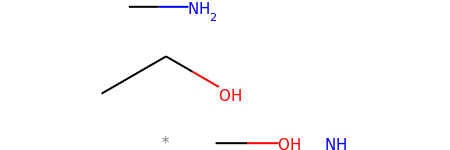

In [19]:
mols[47]

In [22]:
mol = mols[47]
[a.GetExplicitValence() for a in mol.GetAtoms()]

[1, 1, 1, 2, 0, 1, 1, 0, 1]

In [37]:
mol = mols[47]
Chem.MolToSmiles(mol)

'C.C.C.O.O=C=CC=O'

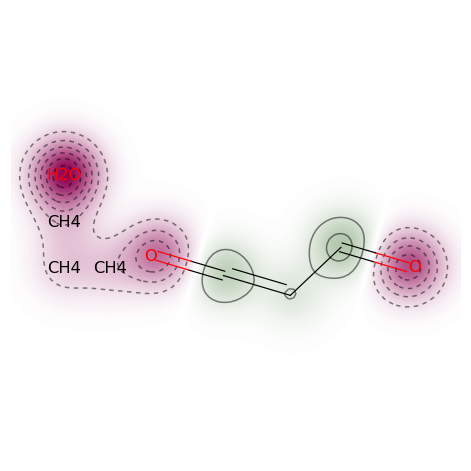

In [36]:
from rdkit.Chem.Draw import SimilarityMaps
import matplotlib
mol = mols[47]
AllChem.ComputeGasteigerCharges(mol)
contribs = [mol.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mol.GetNumAtoms())]
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, colorMap=None,  contourLines=10)

In [39]:
import pickle
import numpy as np

from rdkit import Chem
from datetime import datetime

In [40]:
class SparseMolecularDataset():

    def load(self, filename, subset=1):

        with open(filename, 'rb') as f:
            self.__dict__.update(pickle.load(f))

        self.train_idx = np.random.choice(self.train_idx, int(len(self.train_idx) * subset), replace=False)
        self.validation_idx = np.random.choice(self.validation_idx, int(len(self.validation_idx) * subset),
                                               replace=False)
        self.test_idx = np.random.choice(self.test_idx, int(len(self.test_idx) * subset), replace=False)

        self.train_count = len(self.train_idx)
        self.validation_count = len(self.validation_idx)
        self.test_count = len(self.test_idx)

        self.__len = self.train_count + self.validation_count + self.test_count

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.__dict__, f)

    def generate(self, filename, add_h=False, filters=lambda x: True, size=None, validation=0.1, test=0.1):
        self.log('Extracting {}..'.format(filename))

        if filename.endswith('.sdf'):
            self.data = list(filter(lambda x: x is not None, Chem.SDMolSupplier(filename)))
        elif filename.endswith('.smi'):
            self.data = [Chem.MolFromSmiles(line) for line in open(filename, 'r').readlines()]

        self.data = list(map(Chem.AddHs, self.data)) if add_h else self.data
        self.data = list(filter(filters, self.data))
        self.data = self.data[:size]

        self.log('Extracted {} out of {} molecules {}adding Hydrogen!'.format(len(self.data),
                                                                              len(Chem.SDMolSupplier(filename)),
                                                                              '' if add_h else 'not '))

        self._generate_encoders_decoders()
        self._generate_AX()

        self.data = np.array(self.data)
        self.smiles = np.array(self.smiles)
        self.data_S = np.stack(self.data_S)
        self.data_A = np.stack(self.data_A)
        self.data_X = np.stack(self.data_X)
        self.data_D = np.stack(self.data_D)
        self.data_F = np.stack(self.data_F)
        self.data_Le = np.stack(self.data_Le)
        self.data_Lv = np.stack(self.data_Lv)

        self.vertexes = self.data_F.shape[-2]
        self.features = self.data_F.shape[-1]

        self._generate_train_validation_test(validation, test)

    def _generate_encoders_decoders(self):
        self.log('Creating atoms encoder and decoder..')
        atom_labels = sorted(set([atom.GetAtomicNum() for mol in self.data for atom in mol.GetAtoms()] + [0]))
        self.atom_encoder_m = {l: i for i, l in enumerate(atom_labels)}
        self.atom_decoder_m = {i: l for i, l in enumerate(atom_labels)}
        self.atom_num_types = len(atom_labels)
        self.log('Created atoms encoder and decoder with {} atom types and 1 PAD symbol!'.format(
            self.atom_num_types - 1))

        self.log('Creating bonds encoder and decoder..')
        bond_labels = [Chem.rdchem.BondType.ZERO] + list(sorted(set(bond.GetBondType()
                                                                    for mol in self.data
                                                                    for bond in mol.GetBonds())))

        self.bond_encoder_m = {l: i for i, l in enumerate(bond_labels)}
        self.bond_decoder_m = {i: l for i, l in enumerate(bond_labels)}
        self.bond_num_types = len(bond_labels)
        self.log('Created bonds encoder and decoder with {} bond types and 1 PAD symbol!'.format(
            self.bond_num_types - 1))

        self.log('Creating SMILES encoder and decoder..')
        smiles_labels = ['E'] + list(set(c for mol in self.data for c in Chem.MolToSmiles(mol)))
        self.smiles_encoder_m = {l: i for i, l in enumerate(smiles_labels)}
        self.smiles_decoder_m = {i: l for i, l in enumerate(smiles_labels)}
        self.smiles_num_types = len(smiles_labels)
        self.log('Created SMILES encoder and decoder with {} types and 1 PAD symbol!'.format(
            self.smiles_num_types - 1))

    def _generate_AX(self):
        self.log('Creating features and adjacency matrices..')

        data = []
        smiles = []
        data_S = []
        data_A = []
        data_X = []
        data_D = []
        data_F = []
        data_Le = []
        data_Lv = []

        max_length = max(mol.GetNumAtoms() for mol in self.data)
        max_length_s = max(len(Chem.MolToSmiles(mol)) for mol in self.data)

        for i, mol in enumerate(self.data):
            A = self._genA(mol, connected=True, max_length=max_length)
            D = np.count_nonzero(A, -1)
            if A is not None:
                data.append(mol)
                smiles.append(Chem.MolToSmiles(mol))
                data_S.append(self._genS(mol, max_length=max_length_s))
                data_A.append(A)
                data_X.append(self._genX(mol, max_length=max_length))
                data_D.append(D)
                data_F.append(self._genF(mol, max_length=max_length))

                L = D - A
                Le, Lv = np.linalg.eigh(L)

                data_Le.append(Le)
                data_Lv.append(Lv)

        self.log(date=False)
        self.log('Created {} features and adjacency matrices  out of {} molecules!'.format(len(data),
                                                                                           len(self.data)))

        self.data = data
        self.smiles = smiles
        self.data_S = data_S
        self.data_A = data_A
        self.data_X = data_X
        self.data_D = data_D
        self.data_F = data_F
        self.data_Le = data_Le
        self.data_Lv = data_Lv
        self.__len = len(self.data)

    def _genA(self, mol, connected=True, max_length=None):

        max_length = max_length if max_length is not None else mol.GetNumAtoms()

        A = np.zeros(shape=(max_length, max_length), dtype=np.int32)

        begin, end = [b.GetBeginAtomIdx() for b in mol.GetBonds()], [b.GetEndAtomIdx() for b in mol.GetBonds()]
        bond_type = [self.bond_encoder_m[b.GetBondType()] for b in mol.GetBonds()]

        A[begin, end] = bond_type
        A[end, begin] = bond_type

        degree = np.sum(A[:mol.GetNumAtoms(), :mol.GetNumAtoms()], axis=-1)

        return A if connected and (degree > 0).all() else None

    def _genX(self, mol, max_length=None):

        max_length = max_length if max_length is not None else mol.GetNumAtoms()

        return np.array([self.atom_encoder_m[atom.GetAtomicNum()] for atom in mol.GetAtoms()] + [0] * (
                    max_length - mol.GetNumAtoms()), dtype=np.int32)

    def _genS(self, mol, max_length=None):

        max_length = max_length if max_length is not None else len(Chem.MolToSmiles(mol))

        return np.array([self.smiles_encoder_m[c] for c in Chem.MolToSmiles(mol)] + [self.smiles_encoder_m['E']] * (
                    max_length - len(Chem.MolToSmiles(mol))), dtype=np.int32)

    def _genF(self, mol, max_length=None):

        max_length = max_length if max_length is not None else mol.GetNumAtoms()

        features = np.array([[*[a.GetDegree() == i for i in range(5)],
                              *[a.GetExplicitValence() == i for i in range(9)],
                              *[int(a.GetHybridization()) == i for i in range(1, 7)],
                              *[a.GetImplicitValence() == i for i in range(9)],
                              a.GetIsAromatic(),
                              a.GetNoImplicit(),
                              *[a.GetNumExplicitHs() == i for i in range(5)],
                              *[a.GetNumImplicitHs() == i for i in range(5)],
                              *[a.GetNumRadicalElectrons() == i for i in range(5)],
                              a.IsInRing(),
                              *[a.IsInRingSize(i) for i in range(2, 9)]] for a in mol.GetAtoms()], dtype=np.int32)

        return np.vstack((features, np.zeros((max_length - features.shape[0], features.shape[1]))))

    def matrices2mol(self, node_labels, edge_labels, strict=False):
        mol = Chem.RWMol()

        for node_label in node_labels:
            mol.AddAtom(Chem.Atom(self.atom_decoder_m[node_label]))

        for start, end in zip(*np.nonzero(edge_labels)):
            if start > end:
                mol.AddBond(int(start), int(end), self.bond_decoder_m[edge_labels[start, end]])

        if strict:
            try:
                Chem.SanitizeMol(mol)
            except:
                mol = None

        return mol

    def seq2mol(self, seq, strict=False):
        mol = Chem.MolFromSmiles(''.join([self.smiles_decoder_m[e] for e in seq if e != 0]))

        if strict:
            try:
                Chem.SanitizeMol(mol)
            except:
                mol = None

        return mol

    def _generate_train_validation_test(self, validation, test):

        self.log('Creating train, validation and test sets..')

        validation = int(validation * len(self))
        test = int(test * len(self))
        train = len(self) - validation - test

        self.all_idx = np.random.permutation(len(self))
        self.train_idx = self.all_idx[0:train]
        self.validation_idx = self.all_idx[train:train + validation]
        self.test_idx = self.all_idx[train + validation:]

        self.train_counter = 0
        self.validation_counter = 0
        self.test_counter = 0

        self.train_count = train
        self.validation_count = validation
        self.test_count = test

        self.log('Created train ({} items), validation ({} items) and test ({} items) sets!'.format(
            train, validation, test))

    def _next_batch(self, counter, count, idx, batch_size):
        if batch_size is not None:
            if counter + batch_size >= count:
                counter = 0
                np.random.shuffle(idx)

            output = [obj[idx[counter:counter + batch_size]]
                      for obj in (self.data, self.smiles, self.data_S, self.data_A, self.data_X,
                                  self.data_D, self.data_F, self.data_Le, self.data_Lv)]

            counter += batch_size
        else:
            output = [obj[idx] for obj in (self.data, self.smiles, self.data_S, self.data_A, self.data_X,
                                           self.data_D, self.data_F, self.data_Le, self.data_Lv)]

        return [counter] + output

    def next_train_batch(self, batch_size=None):
        out = self._next_batch(counter=self.train_counter, count=self.train_count,
                               idx=self.train_idx, batch_size=batch_size)
        self.train_counter = out[0]

        return out[1:]

    def next_validation_batch(self, batch_size=None):
        out = self._next_batch(counter=self.validation_counter, count=self.validation_count,
                               idx=self.validation_idx, batch_size=batch_size)
        self.validation_counter = out[0]

        return out[1:]

    def next_test_batch(self, batch_size=None):
        out = self._next_batch(counter=self.test_counter, count=self.test_count,
                               idx=self.test_idx, batch_size=batch_size)
        self.test_counter = out[0]

        return out[1:]

    @staticmethod
    def log(msg='', date=True):
        print(str(datetime.now().strftime('%Y-%m-%d %H:%M:%S')) + ' ' + str(msg) if date else str(msg))

    def __len__(self):
        return self.__len

In [42]:
self = SparseMolecularDataset()

In [44]:
atom_labels = sorted(set([atom.GetAtomicNum() for mol in self.data for atom in mol.GetAtoms()] + [0]))

AttributeError: 'SparseMolecularDataset' object has no attribute 'data'